* [Model](#model) describes the simplified model used for analysis
* [Indifference curves for price - electricity cost configs](#indifference_curves) plots indifference curves for a few eur/btc, electricity cost configs vs. historical data
* [Relationship between mining profitability, hashrate and BTC price](#btc_price_hashrate_relationship) examines how differences in btc/eur exchange rates and hashrate determine mining profitability
* [Conclusions](#conclusions)


<a id='model'></a>
### Model

This model makes the simplifying assumption that hash difficulty adjustments are instantaneous instead of occurring every 2 weeks.

* our_hashrate $\dfrac{Th}{sec}$
* global_hashrate $\dfrac{Th}{sec}$
* fpps_tax $ k \in [0,1]$
* kWh_per_hash $\dfrac{kWh}{Th}$
* eur_per_btc $\dfrac{eur}{btc}$
* eur_per_kWh $\dfrac{eur}{kWh}$
* tx_fee_per_block $\approx 0.5393$
* btc_per_block $\approx 6.25 + tx\_fee\_per\_block = 6.7893$
* blocks_per_day $\approx \dfrac{24 \cdot 60}{10} = 144$

* btc_per_day $\approx btc\_per\_block \cdot blocks\_per\_day \cdot \dfrac{our\_hashrate}{global\_hashrate} \cdot (1 -fpps\_tax)$
* electricity_eur_day $\approx eur\_per\_kWhour \cdot kWh\_per\_hash \cdot our\_hashrate \cdot 24 \cdot 60 \cdot 60$
* eur_per_day $= btc\_per\_day \cdot eur\_per\_btc - electricity\_eur\_day$

#### breakeven calculation

$eur\_per\_day = btc\_per\_day \cdot eur\_per\_btc - electricity\_eur\_day$

$eur\_per\_btc = \dfrac{electricity\_eur\_day + eur\_per\_day}{btc\_per\_day}$

$eur\_per\_btc = \dfrac{electricity\_eur\_day + eur\_per\_day}{btc\_per\_block \cdot blocks\_per\_day \cdot \dfrac{our\_hashrate}{global\_hashrate} \cdot (1 -fpps\_tax)}$

$eur\_per\_btc = \dfrac{(electricity\_eur\_day + eur\_per\_day) \cdot global\_hashrate}{btc\_per\_block \cdot blocks\_per\_day \cdot our\_hashrate \cdot (1 -fpps\_tax)}$

In [1]:
%matplotlib notebook
import gzip
import csv
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as  mpatches
import datetime as dt
import re
import numpy as np
import seaborn as sns

In [2]:
def load_hashrate_th_s():
    """
    Unit: terahashes/second
    """
    df = pd.read_csv('hash-rate.csv')
    df['day'] = [dt.datetime.strptime(stamp.split()[0], '%Y-%m-%d') for stamp in df['Timestamp']]
    df = df[['day', 'hash-rate']]
    df = df.rename(columns={'hash-rate': 'terahashes-second'})
    return df

def load_btc_eur():
    df= pd.read_csv('BTC-EUR.csv')
    df['day'] = [dt.datetime.strptime(d, '%Y-%m-%d') for d in df['Date']]
    df = df[['day','Open', 'Close']]
    df = df.rename(columns={'Open': 'btc_eur_open', 'Close': 'btc_eur_close'})
    return df.dropna()

In [3]:
def eur_per_btc(
    electricity_eur_day,
    eur_per_day,
    global_hashrate, 
    our_hashrate, 
    fpps_tax=0.025, 
    btc_per_block=6.7893, 
    blocks_per_day=144):
    
    num = (electricity_eur_day + eur_per_day) * global_hashrate
    den = btc_per_block * blocks_per_day * our_hashrate * (1 - fpps_tax)
    return num / den

In [4]:
hashrate_df = load_hashrate_th_s()
btc_eur_df = load_btc_eur()

hash_and_btc_eur = hashrate_df.merge(btc_eur_df, how='inner', on='day')
hash_and_btc_eur['terahashes-second'].min(), hash_and_btc_eur['terahashes-second'].max()

(58461000.56974205, 198514005.7096344)

In [5]:
TERAHASHES_SEC = 100 * 14
FPPS_TAX = 0.025
kWh_day = 74.88 * 14

global_hashrate = np.linspace(hash_and_btc_eur['terahashes-second'].min(), hash_and_btc_eur['terahashes-second'].max())
eur_per_btc_breakeven_22 = eur_per_btc(kWh_day * .22, 0, global_hashrate, TERAHASHES_SEC)
eur_per_btc_breakeven_08 = eur_per_btc(kWh_day * .08, 0, global_hashrate, TERAHASHES_SEC)
eur_per_btc_100_eur_day_08 = eur_per_btc(kWh_day * .08, 100, global_hashrate, TERAHASHES_SEC)
eur_per_btc_400_eur_day_08 = eur_per_btc(kWh_day * .08, 400, global_hashrate, TERAHASHES_SEC)

y_2020 = hash_and_btc_eur['day'] < dt.datetime(2021, 1, 1)
y_2021 = hash_and_btc_eur['day'] >= dt.datetime(2021, 1, 1)


<a id='indifference_curves'></a>
### Indifference curves for price - electricity cost configs

<IPython.core.display.Javascript object>


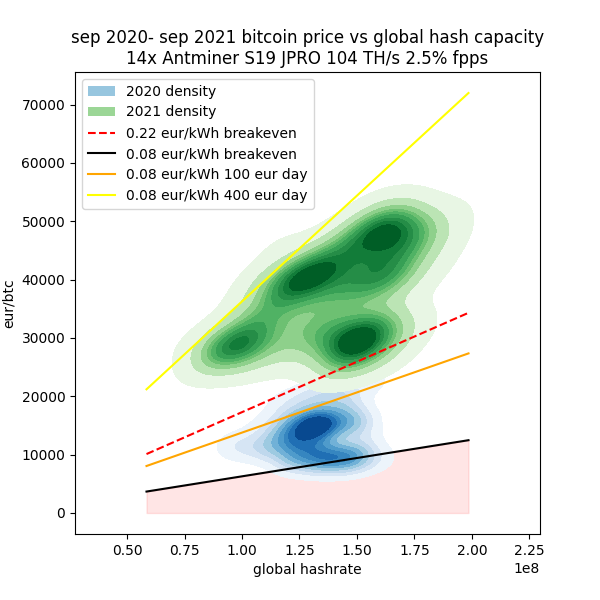

/Users/miguelsimon/mining/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/miguelsimon/mining/env/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


In [6]:
f, ax = plt.subplots(figsize=(6, 6))
ax.set_title("sep 2020- sep 2021 bitcoin price vs global hash capacity\n14x Antminer S19 JPRO 104 TH/s 2.5% fpps")
ax.set_ylabel('eur/btc')
ax.set_xlabel('global hashrate')
ax.plot(global_hashrate, eur_per_btc_breakeven_22, color='red', linestyle='--')

ax.plot(global_hashrate, eur_per_btc_breakeven_08, color='black')
ax.plot(global_hashrate, eur_per_btc_100_eur_day_08, color='orange')
ax.plot(global_hashrate, eur_per_btc_400_eur_day_08, color='yellow')
ax.fill_between(global_hashrate, eur_per_btc_breakeven_08, color='red', alpha=0.1)

sns.kdeplot(
    np.array(hash_and_btc_eur[y_2020]['terahashes-second']), 
    np.array(hash_and_btc_eur[y_2020]['btc_eur_close']), 
    color="blue", 
    cmap="Blues",
    shade=True, 
    ax=ax)

sns.kdeplot(
    np.array(hash_and_btc_eur[y_2021]['terahashes-second']), 
    np.array(hash_and_btc_eur[y_2021]['btc_eur_close']), 
    color="green", 
    cmap="Greens",
    shade=True, 
    ax=ax)

handles = [mpatches.Patch(facecolor=plt.cm.Blues(100), label="2020 density"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="2021 density"),
           plt.Line2D([], [], color='red', linestyle='--', label="0.22 eur/kWh breakeven"),
           plt.Line2D([], [], color='black', label="0.08 eur/kWh breakeven"),
           plt.Line2D([], [], color='orange', label="0.08 eur/kWh 100 eur day"),
           plt.Line2D([], [], color='yellow', label="0.08 eur/kWh 400 eur day"),
          ]
ax.legend(loc="upper left", handles=handles)


<a id='btc_price_hashrate_relationship'></a>
### Relationship between mining profitability, hashrate and BTC price

$$
eur\_per\_btc \cdot btc\_per\_block \cdot blocks\_per\_day \cdot \dfrac{our\_hashrate}{global\_hashrate} \cdot (1 -fpps\_tax)  = electricity\_eur\_day + eur\_per\_day
$$

$$
K = btc\_per\_block \cdot blocks\_per\_day \cdot our\_hashrate \cdot (1 -fpps\_tax)
$$

Let's see how changes in btc price $\delta eur\_btc$ and changes in global hashrate $\delta hashrate$ influence changes in daily mining revenue $\delta eur\_day$.

We add deltas and subtract expressions:

$$
K \cdot \dfrac{eur\_per\_btc}{global\_hashrate} = electricity\_eur\_day + eur\_per\_day
$$

$$
K \cdot \dfrac{eur\_per\_btc + \delta eur\_per\_btc}{global\_hashrate + \delta global\_hashrate} = electricity\_eur\_day + eur\_per\_day + \delta eur\_per\_day
$$

$$
\delta eur\_per\_day = K \cdot \left( \dfrac{eur\_per\_btc + \delta eur\_per\_btc}{global\_hashrate + \delta global\_hashrate} - \dfrac{eur\_per\_btc}{global\_hashrate} \right)
$$

$$
\delta eur\_per\_day = K \cdot \dfrac{\delta eur\_btc \cdot hashrate - \delta hashrate \cdot eur\_btc} {hashrate \cdot \left(hashrate + \delta hashrate \right)}
$$

When is $\delta eur\_day \gt 0$ ?

When 

$$
\delta eur\_btc \cdot hashrate \gt \delta hashrate \cdot eur\_btc
$$

$$
\dfrac{\delta eur\_btc}{eur\_btc} \gt \dfrac{\delta hashrate}{hashrate}
$$

Both these conclusions are pretty obvious

* When btc price increases, miners become more profitable as long as the global hashrate increases more slowly (duh)
* When btc price decreases, miners become more profitable as long as the global hashrate decreases faster than the relative drop in btc price

Slightly less obvious are the implications:

* Miners perform better than BTC when:
    1. BTC increases in price quickly and global hashrate can't increase fast enough
    2. BTC decreases in price *and* you are insensitive to electricity prices *and* you suspect that most miners are operating close to their breakeven point: this means that a small decrease in BTC price will lead to a large(r) decrease in global hash rate, and thus greater profitability for the remaining miners
* In other cases, miners perform worse than simply hodling BTC

<a id='conclusions'></a>
### Conclusions

Forecasting the btc/eur exchange rate is not something that I'd attempt or have any insight about.

*However*, estimating the current and future distribution of miners' breakeven points as a function of btc/eur exchange rate might be feasible. An upper bound on hashrate growth can probably be calculated, and estimates of breakeven points can be created using historical data & prospective electricity prices.

Depending on the conclusions, it's possible that mining makes more sense than hodling btc.

Personally I think doing stuff that *isn't* a modern version of [tulip mania](https://en.wikipedia.org/wiki/Tulip_mania) is a more worthwhile use of time, even if it's ultimately less profitable.